In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.style
matplotlib.style.use("seaborn")
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import textwrap
import seaborn as sn
sn.color_palette("hls", 17)
import scipy.stats as st
import math

import pingouin as pg
plt.rcParams["font.family"] = "Times New Roman"

In [2]:
import sys
import os
sys.path.append(os.path.join("..", "..", ".."))

from mika.kd.trend_analysis import *
from mika.utils import Data
from mika.utils.SAFECOM import *

C:\Users\srandrad\Anaconda3\lib\site-packages\plotly\graph_objs\__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
C:\Users\srandrad\Anaconda3\lib\site-packages\plotly\graph_objs\__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
C:\Users\srandrad\Anaconda3\lib\site-packages\plotly\graph_objs\__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
C:\Users\srandrad\Anaconda3\lib\site-packages\plotly\graph_objs\__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
C:\Users\srandrad\Anaconda3\lib\

In [3]:
csv_file_name = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir, os.pardir)),'data','SAFECOM','SAFECOM_data.csv')
df = pd.read_csv(csv_file_name)
fire_missions = [mission for mission in list(df['Mission Type']) if type(mission) is str and 'fire' in mission.lower()]
df = df.loc[df['Mission Type'].isin(fire_missions)].reset_index(drop=True)
df['Year'] = [df.at[i,'Date'].split('/')[-1] for i in range(len(df))]
df['Day'] = [df.at[i,'Date'].split('/')[1] for i in range(len(df))]
df['Month'] = [df.at[i,'Date'].split('/')[0] for i in range(len(df))]
#df['Year'].value_counts()

C:\Users\srandrad\AppData\Local\Temp\2\ipykernel_4192\3595145697.py:2: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_name)


In [4]:
#NIFC based in boise
#idaho and wyoming are split in regions
def correct_regions(df):
    region_dict ={
        'Region 05 Pacific Southwest Region': ['5', 'California', 'Hawaii', 'Pacific West Regional Office','California State Office','R2-Southwest Regional Office', 'National Guard'],
        'Region 06 Pacific Northwest Region':['Oregon/Washington State Office', 'Washington', 'Oregon', 'Washington Office','R9-Washington Office',
                                             'PNW Research Station FIA','R1-Pacific Regional Office'],
        'Region 01 Northern Rockies Region':['Montana/Dakotas State Office', 'Montana'], 
        'Region 04 Intermountain Region':['Nevada State Office','DOI-OAS - Headquarters Boise', 'Intermountain Regional NPS Headquarters',
                                         'Utah','Utah State Office', 'Nevada', 'National Interagency Fire Center', 'DOI-OAS - Western Region Office',
                                         'DOI-OAS - Technical Services', 'DOI-OAS - Unmanned Aircraft System Office'],
        'Region 03 Southwest Region':['Southeast Region','Arizona State Office','Arizona','New Mexico','New Mexico State Office'],
        'Region 09 Eastern Area Region':['New Jersey', 'Pennsylvania', 'Minnesota','Pennsylvania','Midwest Regional NPS Headquarters','R3-Great Lakes - Big Rivers Regional Office',
                                        'Northeast Regional Office', 'DOI-OAS - Eastern Region Office','Northeastern Area, S&PF','Wisconsin','Eastern States Office','National Capitol Parks'],
        'Region 02 Rocky Mountain Region':['Colorado State Office', 'Colorado','R6-Mountain-Praire Regional Office', 'DMBM - Migratory Birds', 'Wyoming', 'South Dakota', 'Nebraska'], 
        'Region 08 Southern Area Region':['Gulf of Mexico Region','Texas','Oklahoma','North Carolina', 'South Carolina','Florida','R4-Southeast Regional Office', 'Tennessee', 'Georgia', 'Louisiana', 'Virginia'],
        'Region 10 Alaska Region': ['Alaska State Office','Alaska OCS Region', 'Alaska Regional Office', 'Alaska','DOI-OAS - Alaska Regional Office',
                                   'R7-Alaska Regional Office']

    }
    regions_corrected = []
    indices_to_drop = []
    for i in range(len(df)):
        current_region = df.iloc[i]['Region']
        correct_region = None
        for region in region_dict:
            if (region == current_region) or (current_region in region_dict[region]):
                correct_region = region
                break 
        if not correct_region:
            correct_region = current_region
        if correct_region in ['CAMP â€“ Campaign Against Marijuana Program', 'Commercial Aircraft Services', 'Aircraft Operations Center','National Capitol Parks', 'Department of Defense', 'National Guard']:
            indices_to_drop.append(i)
        if correct_region == 'Idaho':
            if df.iloc[i]['Location'] in ['Clear Creak Fire', 'garden valley', 'Idaho City', 'Idaho City Helibase (U98)','Ranft Fire']:
                correct_region = 'Region 04 Intermountain Region'
            else:
                correct_region = 'Region 01 Northern Rockies Region'
        elif correct_region == 'Pacific Region':
            correct_region = 'Region 05 Pacific Southwest Region'
        elif correct_region == 'Idaho State Office':
            if df.iloc[i]['Location'] in ['Granite Creek Fire', '47.512775, -116.002886','Post Falls, ID']:
                correct_region = 'Region 01 Northern Rockies Region'
            else: 
                correct_region = 'Region 04 Intermountain Region'
        elif correct_region == 'Wyoming State Office':
            if df.iloc[i]['Location'] in ['Tokewanna Fire','Rock Springs Sweetwater County', 'Evanston, WY Airport']:
                correct_region = 'Region 04 Intermountain Region'
            else:
                correct_region = 'Region 02 Rocky Mountain Region'
        regions_corrected.append(correct_region)

    df['region_corrected'] = regions_corrected
    df = df.drop(indices_to_drop, axis=0).reset_index(drop=True)
    return df

In [5]:
list_of_attributes = ['Narrative']#, 'corrective_public', 'notes']
extra_cols = ['Agency', 'Region', 'Location', 'Date', 'Date Submitted', 'Tracking #',
              'Mission Type', 'Persons Onboard', 'Departure Point', 'Destination',
              'Special Use', 'Damages', 'Injuries', 'Hazardous Materials', 'Other Mission Type',
              'Type', 'Manufacturer', 'Model', 'Hazard', 'Incident Management',
              'UAS', 'Accident', 'Airspace', 'Maintenance', 'Mishap Prevention'
              ]
document_id_col = 'Tracking #'

file = os.path.join('topic_model_results','preprocessed_data.csv')
safecom = Data()
safecom.load(file, preprocessed=True, id_col=document_id_col, text_columns=list_of_attributes)
preprocessed_df = safecom.data_df
preprocessed_df['Year'] = [preprocessed_df.at[i,'Date'].split('/')[-1] for i in range(len(preprocessed_df))]
preprocessed_df['Day'] = [preprocessed_df.at[i,'Date'].split('/')[1] for i in range(len(preprocessed_df))]
preprocessed_df['Month'] = [preprocessed_df.at[i,'Date'].split('/')[0] for i in range(len(preprocessed_df))]

In [6]:
preprocessed_df.columns

Index(['Agency', 'Region', 'Location', 'Date', 'Date Submitted', 'Tracking #',
       'Mission Type', 'Persons Onboard', 'Departure Point', 'Destination',
       'Special Use', 'Damages', 'Injuries', 'Hazardous Materials',
       'Other Mission Type', 'Type', 'Manufacturer', 'Model', 'Narrative',
       'Hazard', 'UAS', 'Accident', 'Airspace', 'Maintenance',
       'Mishap Prevention', 'Raw_Narrative', 'Year', 'Day', 'Month'],
      dtype='object')

In [7]:
preprocessed_df = preprocessed_df.loc[(preprocessed_df['Year'].astype(int)<2021) & (preprocessed_df['Year'].astype(int)>1994)].reset_index(drop=True)

In [8]:
hazard_file = os.path.join('topic_model_results', 'hazard_interpretation_SAFECOM_Final.xlsx')
results_file = os.path.join('topic_model_results','lda_results.xlsx')

In [9]:
#hazard_info = pd.read_excel(hazard_file, sheet_name=['topic-focused'])

In [10]:
#remove ids from results file and preprocessed_df if the mission is non-fire
non_fire_missions = [mission for mission in list(preprocessed_df['Mission Type']) if type(mission) is str and 'non-fire' in mission.lower()]
ids_to_drop = preprocessed_df.loc[preprocessed_df['Mission Type'].isin(non_fire_missions)]['Tracking #'].tolist()
preprocessed_df = preprocessed_df.loc[~preprocessed_df['Tracking #'].isin(ids_to_drop)].reset_index(drop=True)
print(len(ids_to_drop))

1983


In [11]:
preprocessed_df['Narrative']

0        [practice, target, mile, parachutist, still, j...
1        [agl, jump, spot, horizontal separation, separ...
2        [rpm, switch, stop, generator warn light, decr...
3        [clear, bottom, possible, cortez, found, glass...
4        [help, attack, jump, alaska, minute later, pub...
                               ...                        
12549    [know, input, crew, time, descent, still, miss...
12550    [replacement, blade, service, attention, broug...
12551    [engine, found, aware, bird strike, small, not...
12552    [post, attack, gauge, normal, blade, found, co...
12553    [expect, clearance, believe, maneuver, crew, t...
Name: Narrative, Length: 12554, dtype: object

In [12]:
frequency, docs, hazard_words_per_doc, topics_per_doc, hazard_topics_per_doc = identify_docs_per_hazard(hazard_file, preprocessed_df, results_file, 'Narrative', 'Year', "Tracking #", 'Narrative', doc_topic_dist_field='document topic distribution', topic_thresh=0.2)#,  ids_to_drop= ids_to_drop)

100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [01:15<00:00,  2.91s/it]


In [13]:
#_ = hazard_accuracy(docs, num=15, results_path=os.path.join(os.path.dirname(os.getcwd()),'results','SAFECOM_hazards_lda_topics_Apr-04-2022'))

In [14]:
#frequency, docs = identify_docs_per_hazard(hazard_file, preprocessed_df, results_file, 'Raw_Narrative', 'Year', "Tracking #", 'Narrative_reduced_BERT_topics')

In [15]:
def safecom_severity(passengers, injury, damage):
    key_dict = {"No":0, "Yes":1}
    severity = float(passengers)*(key_dict[injury] + key_dict[damage])
    if np.isnan(severity):
        severity=0
    return severity

In [16]:
def calc_rate(frequency):
    total_hazard_freq = {hazard: sum(frequency[hazard].values()) for hazard in frequency}
    time_period = max([len(frequency[hazard].keys()) for hazard in frequency])
    rates = {hazard: round(total_hazard_freq[hazard]/time_period, 3) for hazard in total_hazard_freq}
    return rates

In [17]:
def calc_severity(docs, preprocessed_df, id_field):
    #time_period = preprocessed_df[time_field].unique()
    time_period = set([t for hazard in docs for t in (docs[hazard].keys())])
    severities = {name:{str(time_p):[] for time_p in time_period} for name in docs}
    for hazard in docs:
        for year in docs[hazard]:
            for doc in docs[hazard][year]:
                doc_df = preprocessed_df.loc[preprocessed_df[id_field] == doc].reset_index(drop=True)
                severities[hazard][year].append(safecom_severity(doc_df.iloc[0]['Persons Onboard'], doc_df.iloc[0]['Injuries'], doc_df.iloc[0]['Damages']))
    total_severities_hazard = {hazard: round(np.average([sev for year in severities[hazard] for sev in severities[hazard][year]]),3) for hazard in severities}
    return severities, total_severities_hazard

In [18]:
def create_table(docs, frequency, preprocessed_df, id_field, categories, subcategories, hazards, time_field, accuracy_file):
    table = pd.DataFrame({"Category": categories, "Subcategory": subcategories, "Hazards": hazards})
    accuracy_df = pd.read_excel(accuracy_file, sheet_name=['Summary'])['Summary']
    time_period = preprocessed_df[time_field].unique()
    severities = {name:{str(time_p):[] for time_p in time_period} for name in hazards}
    rates = {name:{str(time_p):0 for time_p in time_period} for name in hazards}
    total_docs_per_year = preprocessed_df[time_field].value_counts()
    total_rates = {hazard:0 for hazard in hazards}
    total_hazard_freq = {hazard:0 for hazard in hazards}
    total_severities_hazard = {hazard:0 for hazard in hazards}
    total_docs = len(preprocessed_df)
    precision = []
    for hazard in hazards:
        hazard_precision = accuracy_df.loc[accuracy_df['Hazards']==hazard].reset_index(drop=True)['Accuracy'].tolist()[0]
        precision.append(round(hazard_precision,3))
        for year in docs[hazard]:
            year = str(year)
            for doc in docs[hazard][year]:
                doc_df = preprocessed_df.loc[preprocessed_df[id_field] == doc].reset_index(drop=True)
                severities[hazard][year].append(safecom_severity(doc_df.iloc[0]['Persons Onboard'], doc_df.iloc[0]['Injuries'], doc_df.iloc[0]['Damages']))
            rates[hazard][year] = frequency[hazard][year]/total_docs_per_year[year]
            total_hazard_freq[hazard] += frequency[hazard][year]
        total_rates[hazard] = round(total_hazard_freq[hazard]/len(time_period), 3)
        total_severities_hazard[hazard] = round(np.average([sev for year in severities[hazard] for sev in severities[hazard][year]]),3)
    table["Frequency"] = [total_hazard_freq[hazard] for hazard in total_hazard_freq]
    table["Rate"] = [total_rates[hazard] for hazard in total_rates]
    table["Severity"] = [total_severities_hazard[hazard] for hazard in total_severities_hazard]
    table["Precision"] = precision
    return table, severities, rates
    

In [19]:
def get_categories_from_docs(docs, preprocessed_df, id_field, category_fields = ['Hazard', 'UAS', 'Accident', 'Airspace', 'Maintenance', 'Mishap Prevention']):
    categories = {hazard: [] for hazard in docs}
    sub_categories = {hazard: [] for hazard in docs}
    for hazard in docs:
        ids = [id_ for year in docs[hazard] for id_ in docs[hazard][year]]
        hazard_df = preprocessed_df.loc[preprocessed_df[id_field].isin(ids)].reset_index(drop=True)
        #main category is the category with the most reports
        cat_counts = {}
        for cat in category_fields:
            cat_counts[cat] = len(hazard_df.loc[hazard_df[cat].notna()])
        main_category = max(cat_counts, key=cat_counts.get)
        categories[hazard] = main_category
        #subcategories are the most common value in that catgeory
        if len(hazard_df[main_category].value_counts()) == 0:
            sub_categories[hazard] = ""
        else:
            sub_cats = hazard_df[main_category].tolist()
            sub_cats = [cat for sub_cat in sub_cats for cat in str(sub_cat).split(", ")]
            sub_cats =[cat for cat in sub_cats if cat != 'nan']
            sub_cat_series = pd.Series(sub_cats).dropna()
            sub_categories[hazard] = sub_cat_series.value_counts().idxmax(axis = 0)
    return categories, sub_categories

In [20]:
hazards_to_drop = ['Runway Hazards', 'Runway Collisions', 'Refuel Truck Problems']
hazards = [hazard for hazard in frequency if hazard not in hazards_to_drop]
docs = {hazard:docs[hazard] for hazard in hazards}
categories, sub_categories = get_categories_from_docs(docs, preprocessed_df, "Tracking #")
categories = categories.values()
subcategories = sub_categories.values()
accuracy_file = os.path.join('topic_model_results','hazard_extraction_accuracy_final.xlsx')
table, severities, rates = create_table(docs, frequency, preprocessed_df, "Tracking #", categories, subcategories, hazards, 'Year', accuracy_file)

In [21]:
table = table.sort_values(['Category', 'Subcategory'], axis=0).reset_index(drop=True)
df = table[['Category', 'Subcategory']]
ind = pd.MultiIndex.from_frame(df)
table.index = ind
table = table.drop(['Category', 'Subcategory'], axis=1)

In [22]:
table

Hazards  Frequency  \
Category    Subcategory                                                        
Airspace    Intrusion                                   Intrusion        526   
            Intrusion                    Airspace Control Hazards        104   
Hazard      Communications                      Radio Malfunction        826   
            Communications              Jumper Operations Hazards         57   
            Mission Equipment        Helitorch Operations Failure        243   
            Other                           Cargo Letdown Failure        464   
            Other                                    Door Failure        490   
            Pilot Action                      Bucket Drop Failure       1560   
            Pilot Action                      In-flight Collision        112   
            Policy Deviation                       Inadequate PPE         36   
            Policy Deviation        Personnel Duty Hours Exceeded         77   
            Policy Deviation                 Load Limits Exceeded         46   
            Policy Deviation                              Medivac         51   
            Weather                                Severe Weather        330   
Maintenance Caution Light      On-board Caution Light Illuminates        338   
            Chip Light                         Engine Malfunction       1693   
            Electrical                       Avionics Malfunction        517   
            Engine                         Tanker Loading Failure        813   
            Engine                                Oil Malfunction        589   
            Fuel                          Fuel System Malfunction       1793   
            Hydraulic                        Hydraulic Fluid Leak        307   
            Landing Gear                 Landing Gear Malfunction        313   
            Rotor (Main)                   Control Surface Damage        471   

                                 Rate  Severity  Precision  
Category    Subcategory                                     
Airspace    Intrusion          20.231     0.004      1.000  
            Intrusion           4.000     0.029      0.800  
Hazard      Communications     31.769     0.070      0.933  
            Communications      2.192     3.561      0.800  
            Mission Equipment   9.346     0.230      0.800  
            Other              17.846     0.241      0.800  
            Other              18.846     0.690      0.867  
            Pilot Action       60.000     0.401      0.733  
            Pilot Action        4.308     0.759      0.800  
            Policy Deviation    1.385     0.000      0.800  
            Policy Deviation    2.962     0.026      0.800  
            Policy Deviation    1.769     0.065      0.867  
            Policy Deviation    1.962     2.137      1.000  
            Weather            12.692     0.552      0.800  
Maintenance Caution Light      13.000     0.036      1.000  
            Chip Light         65.115     0.108      0.933  
            Electrical         19.885     0.099      0.933  
            Engine             31.269     0.150      0.733  
            Engine             22.654     0.107      1.000  
            Fuel               68.962     0.149      0.733  
            Hydraulic          11.808     0.137      0.933  
            Landing Gear       12.038     0.351      0.933  
            Rotor (Main)       18.115     0.527      0.800

In [23]:
#table.to_csv(os.path.join(os.path.dirname(os.getcwd()), 'results', 'SAFECOM_hazards.csv'))

In [24]:
average_precision = np.average(table['Precision'].tolist())
std_precision = np.std(table['Precision'].tolist())
print(average_precision, std_precision)

0.8607826086956523 0.08990717750606873


In [25]:
docs_per_hazard = {hazard:[doc for year in docs[hazard] for doc in docs[hazard][year]] for hazard in docs}

In [26]:
hazards = []; tracking_num = []

In [27]:
for hazard in docs_per_hazard:
    for num in docs_per_hazard[hazard]:
        hazards.append(hazard)
        tracking_num.append(num)
hazard_docs_df = pd.DataFrame({"Hazard":hazards,
                              "Tracking #": tracking_num})

In [28]:
#hazard_docs_df.to_csv(os.path.join(os.path.dirname(os.getcwd()),'results','SAFECOM_hazards_lda_topics_Apr-04-2022','hazard_docs.csv'))

In [29]:
# fuel_leak_ids = [i for year in docs['Fuel Leak'] for i in docs['Fuel Leak'][year]]
# fuel_ids = [i for year in docs['Fuel System Malfunction'] for i in docs['Fuel System Malfunction'][year]]
# fuel_ids_total = fuel_ids + fuel_leak_ids
# fuel_df = pd.read_csv("fuel.csv")
# non_identified_df = fuel_df.loc[(~fuel_df['Tracking #'].isin(fuel_ids_total)) & (~fuel_df['Tracking #'].isin(ids_to_drop))].reset_index(drop=True)
# topics = [[] for i in range(len(non_identified_df))]
# results = pd.read_excel(results_file, sheet_name=['Narrative'])['Narrative']
# non_ids = [id_ for id_ in non_identified_df['Tracking #'].tolist()]
# for i in range(len(results)):
#     doc_ids = [i.strip("'") for i in results.iloc[i]["documents"].strip("[]").split(", ")]
#     topic = results.iloc[i]['topic number']
#     if any(i in doc_ids for i in non_ids):
#         ids = [i  for i in non_ids if i in doc_ids]
#         ids_ind =[non_ids.index(id_) for id_ in ids]
#         for ind in ids_ind:
#             topics[ind].append(topic)
# non_identified_df['Topics'] = topics
# non_identified_df.to_csv("fuel_unidentified.csv")

In [30]:
#print(table.to_latex())

In [31]:
hazards_for_analysis = ['Hydraulic Fluid Leak', 'Intrusion', 'Bucket Drop Failure','Radio Malfunction',
                       'Jumper Operations Hazards', 'Tanker Loading Failure', 'Helitorch Operations Failure',
                       'Cargo Letdown Failure', 'Severe Weather']

In [32]:
#updat: frequency, docs, severities, rates, hazards
frequency = {hazard: frequency[hazard] for hazard in hazards_for_analysis}
docs = {hazard: docs[hazard] for hazard in hazards_for_analysis}
severities = {hazard: severities[hazard] for hazard in hazards_for_analysis}
rates = {hazard: rates[hazard] for hazard in hazards_for_analysis}
hazards = hazards_for_analysis

C:\Users\srandrad\Anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\srandrad\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\srandrad\Anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\srandrad\Anaconda3\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\srandrad\Anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


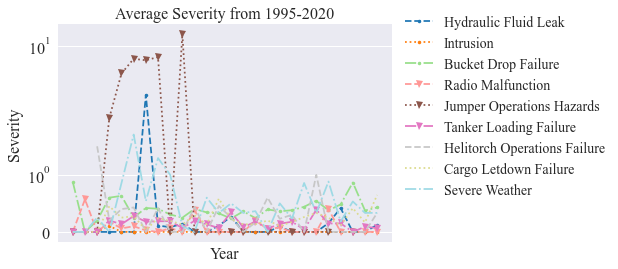

In [33]:
markers = ['.','.','.', 'v', 'v','v', 'x', 'x', 'x']
line_styles = ['--', ':','-.','--', ':','-.','--', ':','-.']

plot_metric_time_series(metric_data=severities, metric_name="Severity", line_styles=line_styles, markers=markers, title="Average Severity from 1995-2020", yscale='log', time_name='Year', show_std=False, save=False)
#plot_metric_time_series(metric_data=severities, metric_name="Severity", line_styles=line_styles, markers=markers, title="Average Severity from 1995-2020", time_name='Year', show_std=True, save=False)

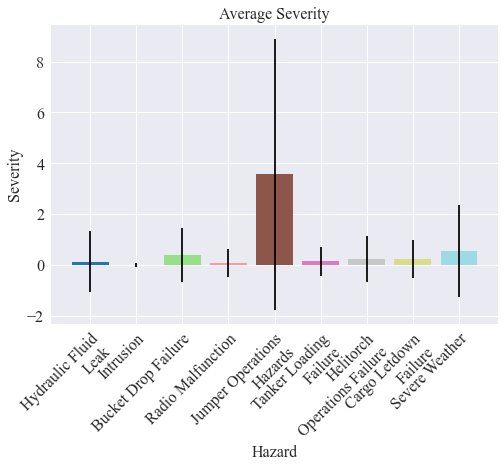

In [34]:
plot_metric_averages(metric_data=severities, metric_name="Severity", show_std=True, title="Average Severity", save=False, legend=False)

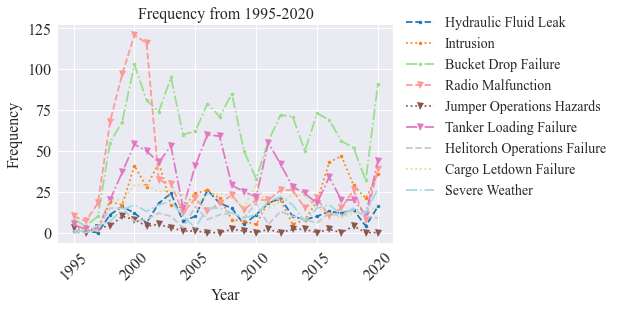

In [35]:
plot_frequency_time_series(frequency, metric_name='Frequency', line_styles=line_styles, markers=markers, title="Frequency from 1995-2020", time_name="Year", scale=False, save=False)

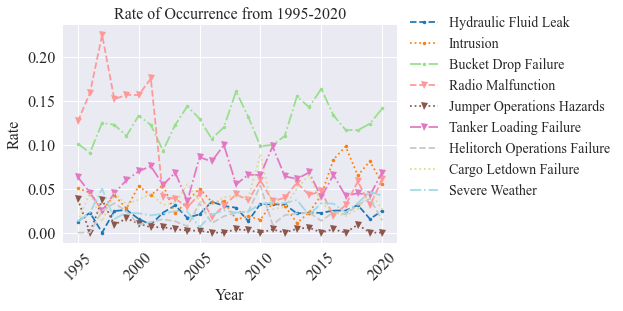

In [36]:
plot_frequency_time_series(rates, metric_name='Rate', line_styles=line_styles, markers=markers, title="Rate of Occurrence from 1995-2020", time_name="Year", scale=False, save=False)

# Pie Charts

In [37]:
def make_pie_chart(docs, data, predictor, hazards, id_field, predictor_label=None, save=True):
    if not predictor_label: predictor_label=predictor
    num_rows = int(np.ceil(len(hazards)/3))
    extra_axes = len(hazards)%3
    fig, axes = plt.subplots(num_rows, 3, figsize=(17,9))
    if extra_axes>0:
        for x in range(1,extra_axes):
            fig.delaxes(axes[num_rows-1][3-x])
    #set up lables, colors dict
    total_docs_with_hazards = [doc for hazard in hazards for year in docs[hazard] for doc in docs[hazard][year] ]
    labels = data.loc[data[id_field].isin(total_docs_with_hazards)][predictor].value_counts().index.sort_values()
    colors = cm.coolwarm(np.linspace(0, 1, len(labels)))
    for ax, hazard in zip(axes.flatten(), hazards):
        total_docs = [doc for year in docs[hazard] for doc in docs[hazard][year]]
        hazard_data = data.loc[data[id_field].isin(total_docs)].reset_index(drop=True)
        val_counts = hazard_data[predictor].value_counts()
        values = [val_counts[val] if val in val_counts else 0 for val in labels]
        _, _, autopct = ax.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', textprops={'fontsize': 12},labeldistance=None, pctdistance=1.2)
        for txt in autopct:
            if float(txt.get_text().strip("%"))<3.0:
                txt.set_visible(False)
                
        ax.set_title(hazard+" per "+predictor_label, fontdict={'fontsize': 14})
    axes[0,0].legend(bbox_to_anchor=(-0.2, 1),fontsize=14)
    plt.savefig('SAFECOM_hazard_'+predictor+'.pdf', bbox_inches="tight") 
    plt.show()

In [38]:
print(len(preprocessed_df))
preprocessed_df = correct_regions(preprocessed_df)#correct_regions(preprocessed_df)
print(len(preprocessed_df))
preprocessed_df.columns

12554
12551


Index(['Agency', 'Region', 'Location', 'Date', 'Date Submitted', 'Tracking #',
       'Mission Type', 'Persons Onboard', 'Departure Point', 'Destination',
       'Special Use', 'Damages', 'Injuries', 'Hazardous Materials',
       'Other Mission Type', 'Type', 'Manufacturer', 'Model', 'Narrative',
       'Hazard', 'UAS', 'Accident', 'Airspace', 'Maintenance',
       'Mishap Prevention', 'Raw_Narrative', 'Year', 'Day', 'Month',
       'region_corrected'],
      dtype='object')

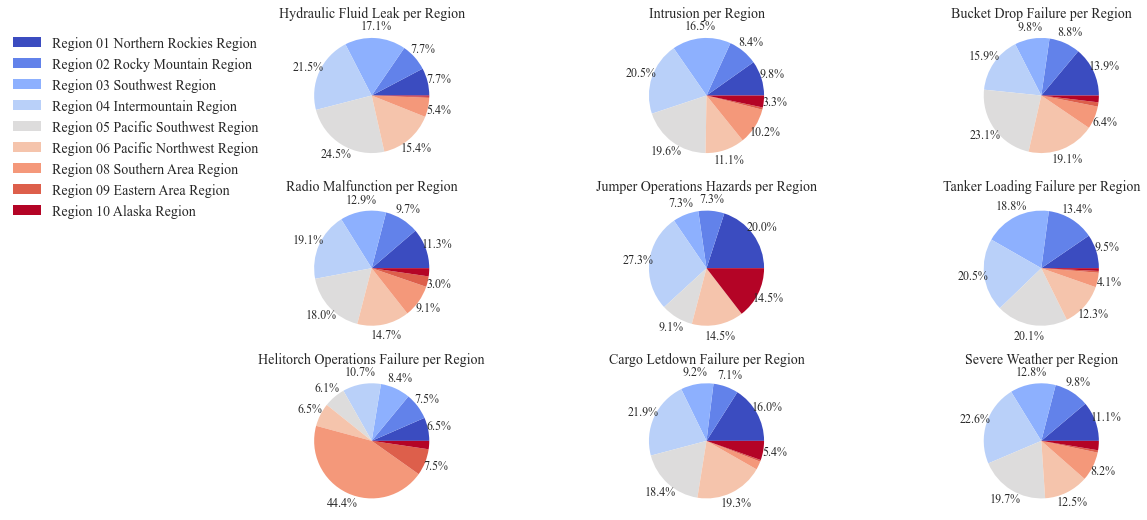

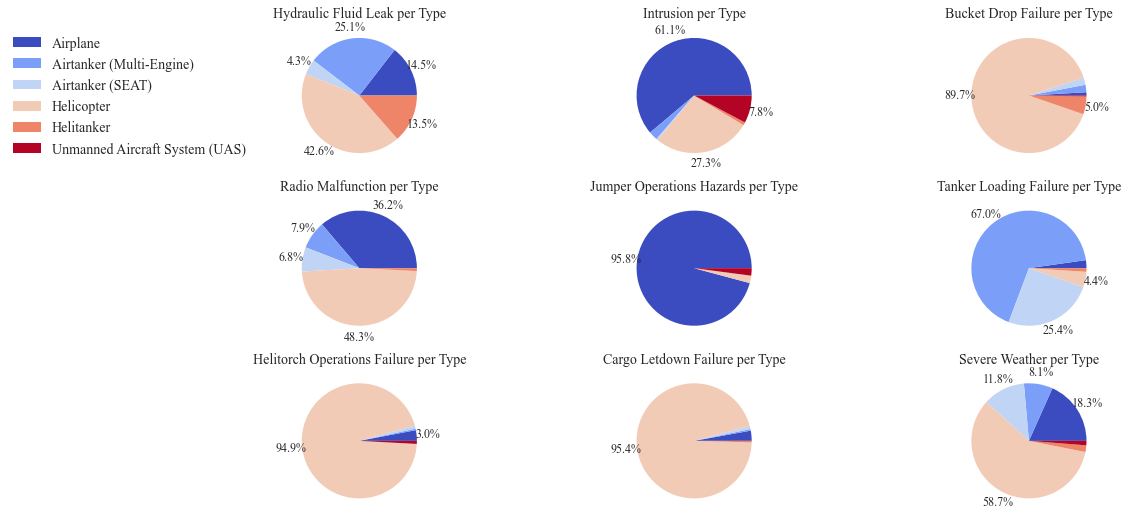

In [39]:
predictors = ['region_corrected', 'Type']#, 'Manufacturer', 'Model','Mission Type']
for predictor in predictors:
    if predictor == 'region_corrected': 
        predictor_label='Region'
    else:
        predictor_label = None
    make_pie_chart(docs, preprocessed_df, predictor, hazards, 'Tracking #', predictor_label, save=False)

# Chi-Squared Analysis

In [40]:
#add hazard values to preprocessed_df
hazards_per_doc = {doc:[] for doc in preprocessed_df['Tracking #']}
hazards_col = ["None" for i in range(len(preprocessed_df))]
hazards_for_df = {hazard:[0 for i in range(len(preprocessed_df))] for hazard in docs}
for hazard in docs:
    for year in docs[hazard]:
        for doc in docs[hazard][year]:
            if doc in preprocessed_df['Tracking #'].tolist():
                hazards_for_df[hazard][preprocessed_df.index[preprocessed_df['Tracking #']==doc].tolist()[0]] = 1
                if hazards_col[preprocessed_df.index[preprocessed_df['Tracking #']==doc][0]] =="None":
                    hazards_col[preprocessed_df.index[preprocessed_df['Tracking #']==doc][0]] = hazard
                else:
                    hazards_col[preprocessed_df.index[preprocessed_df['Tracking #']==doc][0]] += hazard
    preprocessed_df[hazard] = hazards_for_df[hazard]
preprocessed_df['hazard'] = hazards_col
#add severities
severities = []
for i in range(len(preprocessed_df)):
    severities.append(safecom_severity(preprocessed_df.iloc[i]['Persons Onboard'], preprocessed_df.iloc[i]['Injuries'], preprocessed_df.iloc[i]['Damages']))
preprocessed_df["severity"] = severities

In [41]:
count_dfs = {}
pred_dict = {'region_corrected':'Region', 'Type': "Aircraft Type", 'Agency':'Agency'}
stat_vals = {(pred_dict[pred],val): [] for pred in predictors for val in ["chi-squared", "p-val"]}
for predictor in predictors:
    vals = []
    hazard_vals = []
    pred_vals = [val for val in preprocessed_df[predictor].value_counts().index]
    diff_observed_expected = {pred_val:[] for pred_val in pred_vals}
    for hazard in hazards:
        expected, observed, stats = pg.chi2_independence(preprocessed_df, x=predictor,y=hazard)
        stat_vals[(pred_dict[predictor], "p-val")].append((stats.iloc[0]['pval'].round(3)))
        stat_vals[(pred_dict[predictor], "chi-squared")].append((stats.iloc[0]['chi2'].round(3)))
        for i in range(len(expected)):
            pred_val = expected.index[i]
            diff_observed_expected[pred_val].append(observed.iloc[i][0] - expected.iloc[i][0])
            diff_observed_expected[pred_val].append(observed.iloc[i][1] - expected.iloc[i][1])
    iterables = [hazards, [0,1]]
    index = pd.MultiIndex.from_product(iterables, names=["Hazard", "Present"])
    pred_df = pd.DataFrame(diff_observed_expected, index=index)
    count_dfs[predictor] = pred_df
iterables = [[pred_dict[pred] for pred in predictors], ["p-val", "chi-squared"]]
index = pd.MultiIndex.from_product(iterables, names=["Predictor", "Measure"])
stats_df = pd.DataFrame(stat_vals, index=hazards, columns=index)

C:\Users\srandrad\Anaconda3\lib\site-packages\scipy\stats\stats.py:6716: RuntimeWarning: divide by zero encountered in power
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
C:\Users\srandrad\Anaconda3\lib\site-packages\scipy\stats\stats.py:6716: RuntimeWarning: invalid value encountered in multiply
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
C:\Users\srandrad\Anaconda3\lib\site-packages\scipy\stats\stats.py:6713: RuntimeWarning: divide by zero encountered in true_divide
  terms = 2.0 * special.xlogy(f_exp, f_exp / f_obs)
C:\Users\srandrad\Anaconda3\lib\site-packages\scipy\stats\stats.py:6716: RuntimeWarning: divide by zero encountered in power
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
C:\Users\srandrad\Anaconda3\lib\site-packages\scipy\stats\stats.py:6716: RuntimeWarning: invalid value encountered in multiply
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
C:\Users\srandrad\Anaconda3\lib\site-packages\scipy\stats\stats.py:6713: RuntimeWarning: divide by zero encountered i

In [42]:
stats_df

Predictor                    Region             Aircraft Type            
Measure                       p-val chi-squared         p-val chi-squared
Hydraulic Fluid Leak          0.002      25.059           0.0     116.767
Intrusion                     0.020      18.140           0.0     859.401
Bucket Drop Failure           0.000      68.905           0.0    1012.344
Radio Malfunction             0.000      29.167           0.0     128.066
Jumper Operations Hazards     0.000      38.271           0.0     155.562
Tanker Loading Failure        0.000      93.628           0.0    2886.772
Helitorch Operations Failure  0.000     446.140           0.0     166.121
Cargo Letdown Failure         0.000      56.444           0.0     333.714
Severe Weather                0.339       9.035           0.0      43.334

In [43]:
#print(stats_df.to_latex())

In [44]:
for df in count_dfs:
    display(count_dfs[df])

Region 05 Pacific Southwest Region  \
Hazard                       Present                                       
Hydraulic Fluid Leak         0                                 -9.759172   
                             1                                  9.759172   
Intrusion                    0                                  7.652204   
                             1                                 -7.652204   
Bucket Drop Failure          0                                -26.226652   
                             1                                 26.226652   
Radio Malfunction            0                                 23.889853   
                             1                                -23.889853   
Jumper Operations Hazards    0                                  6.671965   
                             1                                 -6.671965   
Tanker Loading Failure       0                                  8.802990   
                             1                                 -8.802990   
Helitorch Operations Failure 0                                 32.414555   
                             1                                -32.414555   
Cargo Letdown Failure        0                                 12.192456   
                             1                                -12.192456   
Severe Weather               0                                  4.726351   
                             1                                 -4.726351   

                                      Region 04 Intermountain Region  \
Hazard                       Present                                   
Hydraulic Fluid Leak         0                            -11.615087   
                             1                             11.615087   
Intrusion                    0                            -13.797405   
                             1                             13.797405   
Bucket Drop Failure          0                             23.970960   
                             1                            -23.970960   
Radio Malfunction            0                            -11.213506   
                             1                             11.213506   
Jumper Operations Hazards    0                             -5.331644   
                             1                              5.331644   
Tanker Loading Failure       0                            -22.830398   
                             1                             22.830398   
Helitorch Operations Failure 0                             14.618696   
                             1                            -14.618696   
Cargo Letdown Failure        0                            -18.289973   
                             1                             18.289973   
Severe Weather               0                            -15.384569   
                             1                             15.384569   

                                      Region 06 Pacific Northwest Region  \
Hazard                       Present                                       
Hydraulic Fluid Leak         0                                  0.828937   
                             1                                 -0.828937   
Intrusion                    0                                 22.272016   
                             1                                -22.272016   
Bucket Drop Failure          0                                -47.541112   
                             1                                 47.541112   
Radio Malfunction            0                                  7.915199   
                             1                                 -7.915199   
Jumper Operations Hazards    0                                  0.642925   
                             1                                 -0.642925   
Tanker Loading Failure       0                                 26.515250   
                             1                                -26.515250   
Helitorch Op

Helicopter    Airplane  \
Hazard                       Present                           
Hydraulic Fluid Leak         0         33.699127   22.845571   
                             1        -33.699127  -22.845571   
Intrusion                    0        125.593349 -185.988475   
                             1       -125.593349  185.988475   
Bucket Drop Failure          0       -553.691225  325.081330   
                             1        553.691225 -325.081330   
Radio Malfunction            0         40.646691 -105.981890   
                             1        -40.646691  105.981890   
Jumper Operations Hazards    0         24.774119  -35.410603   
                             1        -24.774119   35.410603   
Tanker Loading Failure       0        396.716497  159.372407   
                             1       -396.716497 -159.372407   
Helitorch Operations Failure 0        -96.814208   44.843925   
                             1         96.814208  -44.843925   
Cargo Letdown Failure        0       -191.071946   88.040500   
                             1        191.071946  -88.040500   
Severe Weather               0        -16.098617   12.037208   
                             1         16.098617  -12.037208   

                                      Airtanker (Multi-Engine)  \
Hazard                       Present                             
Hydraulic Fluid Leak         0                      -32.675091   
                             1                       32.675091   
Intrusion                    0                       56.061574   
                             1                      -56.061574   
Bucket Drop Failure          0                      187.770250   
                             1                     -187.770250   
Radio Malfunction            0                       47.953902   
                             1                      -47.953902   
Jumper Operations Hazards    0                        6.863352   
                             1                       -6.863352   
Tanker Loading Failure       0                     -424.038854   
                             1                      424.038854   
Helitorch Operations Failure 0                       32.601827   
                             1                      -32.601827   
Cargo Letdown Failure        0                       63.487817   
                             1                      -63.487817   
Severe Weather               0                       20.041653   
                             1                      -20.041653   

                                      Airtanker (SEAT)  Helitanker  \
Hazard                       Present                                 
Hydraulic Fluid Leak         0                3.237488  -29.152371   
                             1               -3.237488   29.152371   
Intrusion                    0               23.508396   14.612117   
                             1              -23.508396  -14.612117   
Bucket Drop Failure          0               51.366398  -16.901630   
                             1              -51.366398   16.901630   
Radio Malfunction            0              -10.915377   23.247613   
                             1               10.915377  -23.247613   
Jumper Operations Hazards    0                2.572275    1.876852   
                             1               -2.572275   -1.876852   
Tanker Loading Failure       0             -160.914389   23.437274   
                             1              160.914389  -23.437274   
Helitorch Operations Failure 0               10.593431    9.188755   
                             1              -10.593431   -9.188755   
Cargo Letdown Failure        0               20.543793   15.908298   
                             1              -20.543793  -15.908298   
Severe Weather               0              -20.744320    6.590550   
                             1               20.744320   -6.590550   

                                   

# ANOVA 

In [45]:
severities_dict = {hazard:[] for hazard in hazards}
AOV_df = {'hazard':[], 'severity':[]}
for hazard in hazards:
    hazard_df = preprocessed_df.loc[preprocessed_df[hazard] == 1]
    sevs = hazard_df['severity'].tolist()
    severities_dict[hazard] = sevs
    for sev in sevs:
        AOV_df['hazard'].append(hazard)
        AOV_df['severity'].append(sev)
AOV_df = pd.DataFrame(AOV_df)

In [46]:
anovas = []
for hazard in hazards:
    aov = pg.welch_anova(dv='severity', between=hazard, data=preprocessed_df).round(3)
    anovas.append(aov)
anova_results = pd.concat(anovas)
anova_results

,Source,ddof1,ddof2,F,p-unc,np2
0,Hydraulic Fluid Leak,1,316.369,1.159,0.282,0.000
0,Intrusion,1,9850.055,465.921,0.000,0.002
0,Bucket Drop Failure,1,1956.480,60.529,0.000,0.005
0,Radio Malfunction,1,1276.591,50.390,0.000,0.001
0,Jumper Operations Hazards,1,56.014,22.232,0.000,0.053
0,Tanker Loading Failure,1,1194.943,8.162,0.004,0.000
0,Helitorch Operations Failure,1,252.425,0.149,0.700,0.000
0,Cargo Letdown Failure,1,528.852,0.883,0.348,0.000
0,Severe Weather,1,334.026,12.572,0.000,0.003


In [47]:
aov = pg.welch_anova(dv='severity', between='hazard', data=AOV_df).round(3)

In [48]:
aov

,Source,ddof1,ddof2,F,p-unc,np2
0,hazard,8,801.128,47.56,0.0,0.115


In [49]:
print(aov.to_latex())

\begin{tabular}{llrrrrr}
\toprule
{} &  Source &  ddof1 &    ddof2 &      F &  p-unc &    np2 \\
\midrule
0 &  hazard &      8 &  801.128 &  47.56 &    0.0 &  0.115 \\
\bottomrule
\end{tabular}



In [50]:
post_hoc = pg.pairwise_gameshowell(dv='severity', between='hazard',  data=AOV_df).round(3)

In [51]:
post_hoc = post_hoc.loc[post_hoc['pval']<0.05].reset_index(drop=True)

In [52]:
post_hoc = post_hoc[['A', 'B', 'df', 'T', 'pval', 'hedges']]
post_hoc.index = post_hoc['A']
post_hoc = post_hoc.drop(['A'], axis=1)
post_hoc

,B,df,T,pval,hedges
A,,,,,
Bucket Drop Failure,Cargo Letdown Failure,1068.375,3.672,0.008,0.194
Bucket Drop Failure,Hydraulic Fluid Leak,404.274,3.608,0.010,0.225
Bucket Drop Failure,Intrusion,1621.209,14.776,0.000,0.745
Bucket Drop Failure,Jumper Operations Hazards,56.156,-4.422,0.001,-0.596
Bucket Drop Failure,Radio Malfunction,2381.847,10.162,0.000,0.437
Bucket Drop Failure,Tanker Loading Failure,2366.974,7.535,0.000,0.326
Cargo Letdown Failure,Intrusion,474.287,6.855,0.000,0.436
Cargo Letdown Failure,Jumper Operations Hazards,56.261,-4.643,0.001,-0.651
Cargo Letdown Failure,Radio Malfunction,741.818,4.363,0.000,0.253


In [53]:
print(post_hoc.to_latex())

\begin{tabular}{llrrrr}
\toprule
{} &                          B &        df &       T &   pval &  hedges \\
A                            &                            &           &         &        &         \\
\midrule
Bucket Drop Failure          &      Cargo Letdown Failure &  1068.375 &   3.672 &  0.008 &   0.194 \\
Bucket Drop Failure          &       Hydraulic Fluid Leak &   404.274 &   3.608 &  0.010 &   0.225 \\
Bucket Drop Failure          &                  Intrusion &  1621.209 &  14.776 &  0.000 &   0.745 \\
Bucket Drop Failure          &  Jumper Operations Hazards &    56.156 &  -4.422 &  0.001 &  -0.596 \\
Bucket Drop Failure          &          Radio Malfunction &  2381.847 &  10.162 &  0.000 &   0.437 \\
Bucket Drop Failure          &     Tanker Loading Failure &  2366.974 &   7.535 &  0.000 &   0.326 \\
Cargo Letdown Failure        &                  Intrusion &   474.287 &   6.855 &  0.000 &   0.436 \\
Cargo Letdown Failure        &  Jumper Operations Hazards &    56.

# Risk Matrix

In [54]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams["font.family"] = "Times New Roman"

In [55]:
severities = table['Severity']
severities.index = table['Hazards']
severities_raw = severities[hazards]
severities_raw = severities_raw.to_dict()
severities = get_SAFECOM_severity_FAA(severities_raw)
rates = table['Rate']
rates.index = table['Hazards']
rates = rates[hazards]
rates = rates.to_dict()
likelihood = get_likelihood_FAA(rates)

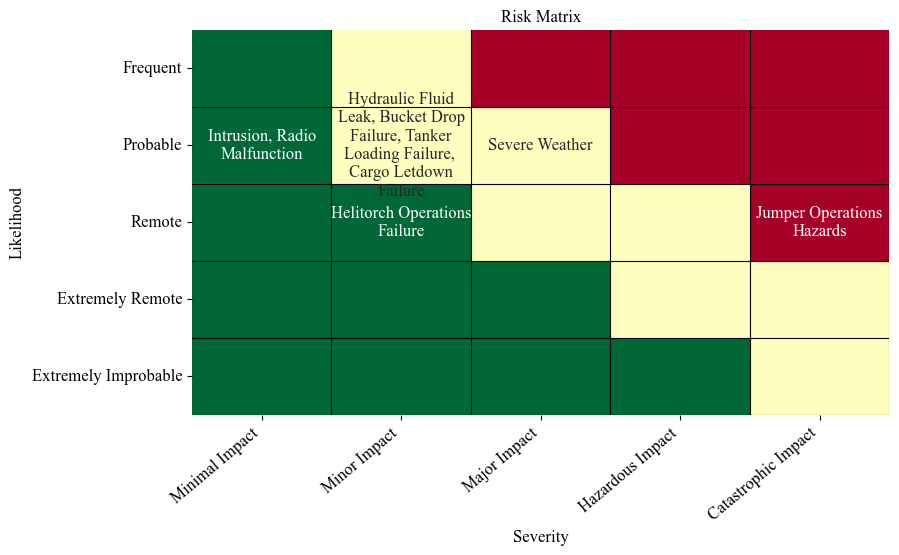

In [56]:
plot_risk_matrix(likelihood, severities, figsize=(9,5), save=False, results_path=os.path.join("SAFECOM_JAIS_rm"))

In [57]:
#plot_risk_matrix(rates={}, severities={}, figsize=(6,3), save=True)

In [58]:
severities_USFS = get_SAFECOM_severity_USFS(severities_raw)
likelihood = get_likelihood_USFS(rates)

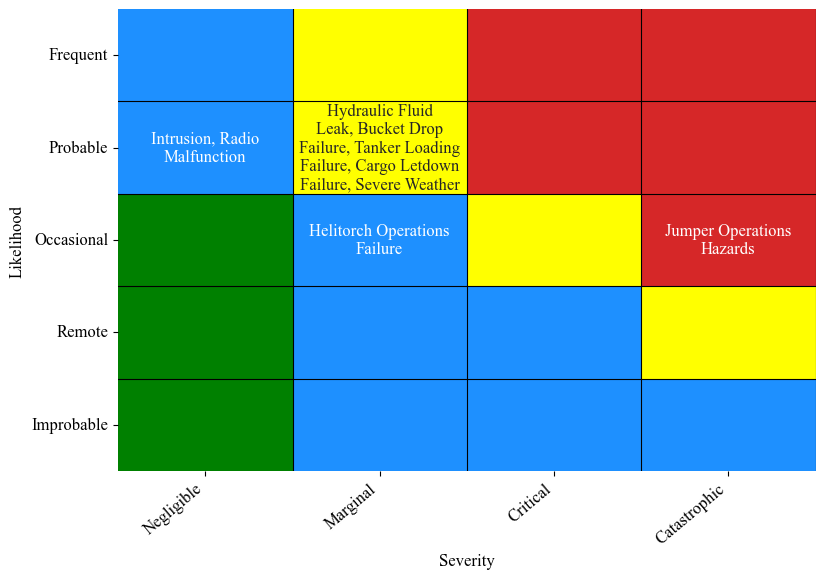

In [59]:
plot_USFS_risk_matrix(likelihood, severities_USFS, figsize=(9,6), save=True, results_path="SAFECOM_JAIS_USFS_risk_matrix", fontsize=12, max_chars=24, title=False)

# Situation Specific Risk Matrices

In [60]:
def filter_df(df, filters):
    for col in filters:
        df = df.dropna(subset=[col])
        df = df[df[col].apply(lambda x: filters[col] in x)].reset_index(drop=True)
    return df

In [61]:
def get_custom_rm(df, filters, hazard_file, results_file, keep_hazards=[]):
    preprocessed_df = filter_df(df, filters)
    frequency, docs, hazard_words_per_doc, topics_per_doc, hazard_topics_per_doc = identify_docs_per_hazard(hazard_file, preprocessed_df, results_file, 'Narrative', 'Year', "Tracking #", 'Narrative', doc_topic_dist_field='document topic distribution', topic_thresh=0.2)
    rates = calc_rate(frequency)
    _, severities = calc_severity(docs, preprocessed_df, id_field='Tracking #')
    #replace nans with 0
    severities = {hazard:severities[hazard] if (not np.isnan(severities[hazard])) else 0 for hazard in severities}
    if keep_hazards == []: keep_hazards = [hazard for hazard in docs]
    #rm extra hazards
    severities = {hazard: severities[hazard] for hazard in severities if hazard in keep_hazards}
    rates = {hazard: rates[hazard] for hazard in rates if hazard in keep_hazards}
    severities_USFS = get_SAFECOM_severity_USFS(severities)
    likelihood = get_likelihood_USFS(rates)
    plot_USFS_risk_matrix(likelihood, severities_USFS, figsize=(9,7), save=False, results_path="", fontsize=10, max_chars=30, title=False)

### Example 1: Aerial commander flying an Aero Commander airplane in California

In [62]:
keep_hazards = ['Hydraulic Fluid Leak','Intrusion','Bucket Drop Failure','Radio Malfunction','Jumper Operations Hazards',
                'Tanker Loading Failure','Helitorch Operations Failure', 'Cargo Letdown Failure','Severe Weather',
               'Fuel System Malfunction', 'Landing Gear Malfunction', 'Engine Malfunction', 'Oil Malfunction', 'Control Surface Damage',
               'In-flight Collision', 'Door Failure']

100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 27.84it/s]
C:\Users\srandrad\Anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\srandrad\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


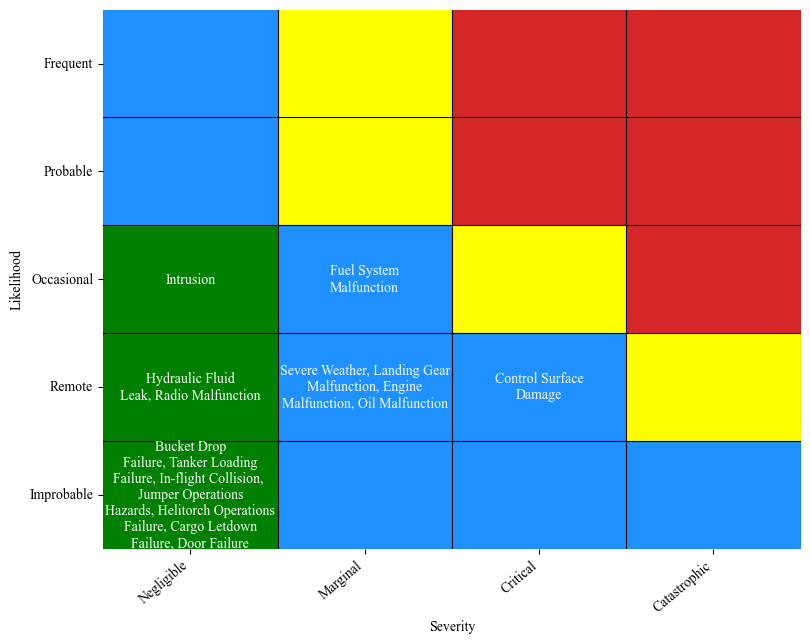

In [63]:
filters ={"Mission Type":'Fire, Air Attack',
          "Type":'Airplane',
         "Manufacturer":'Aero Commander',
         "region_corrected":'Region 05 Pacific Southwest Region'}
get_custom_rm(preprocessed_df, filters, hazard_file, results_file, keep_hazards)

### Example 2: Air Tanker flying a redardant drop mission with a Lockheed multi-engine in Oregon

100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 48.93it/s]
C:\Users\srandrad\Anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\srandrad\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


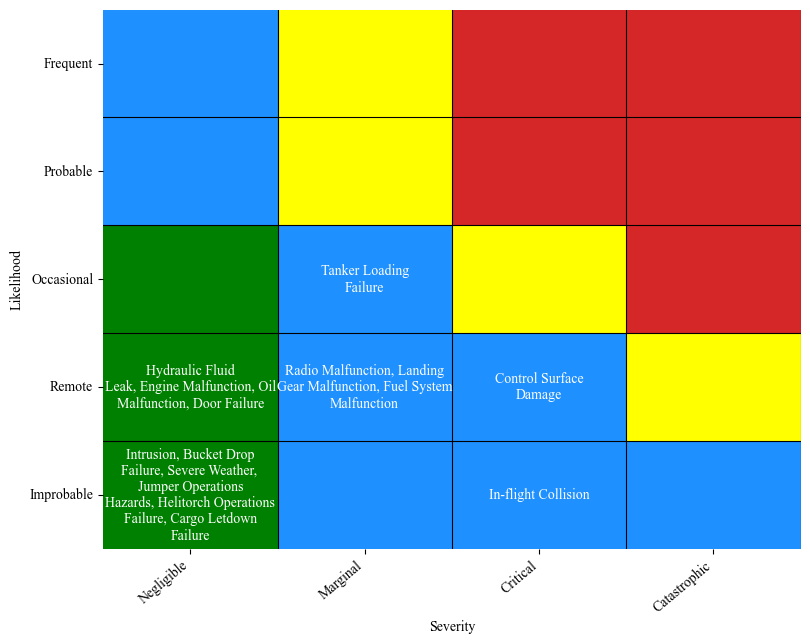

In [64]:
filters ={"Mission Type":'Fire, Retardant Drop (Airtanker)',
         "Type":'Airtanker (Multi-Engine)',
          "Manufacturer": "Lockheed",
         'region_corrected':'Region 06 Pacific Northwest Region'}
get_custom_rm(preprocessed_df, filters, hazard_file, results_file, keep_hazards)

### Example 3: Pilot flying a Bell Helicopter for reconnaisance in Texas

100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 54.82it/s]
C:\Users\srandrad\Anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\srandrad\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


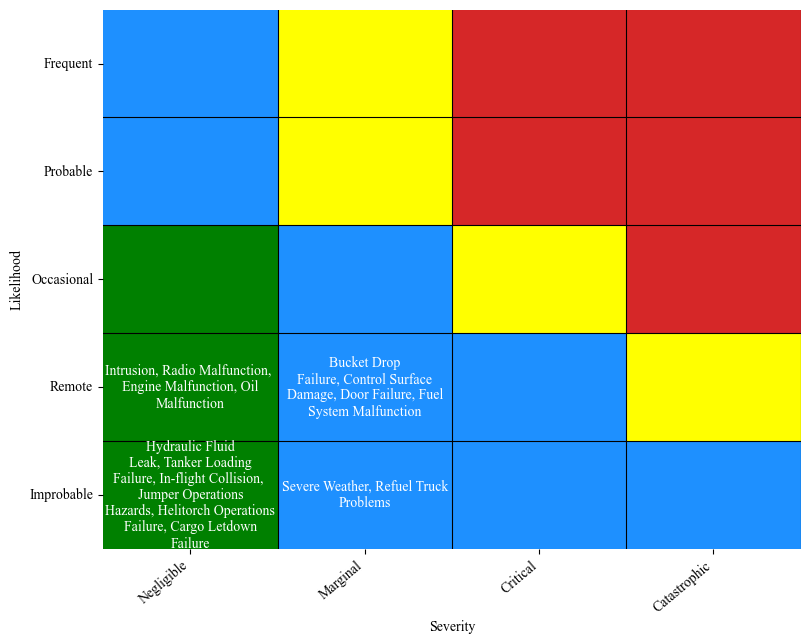

In [65]:
filters ={"Mission Type":'Fire, Reconnaissance',
         "Type":'Helicopter',
          "Manufacturer": "Bell",
          #"Model":"600",#includes 600
          'region_corrected':'Region 08 Southern Area Region'}
keep_hazards = ['Hydraulic Fluid Leak','Intrusion','Bucket Drop Failure','Radio Malfunction','Jumper Operations Hazards',
                'Tanker Loading Failure','Helitorch Operations Failure', 'Cargo Letdown Failure','Severe Weather',
               'Fuel System Malfunction', 'Engine Malfunction', 'Oil Malfunction', 'Control Surface Damage',
               'In-flight Collision', 'Door Failure', 'Refuel Truck Problems']
get_custom_rm(preprocessed_df, filters, hazard_file, results_file, keep_hazards)